In [1]:
import numpy as np
import sklearn.cluster

import tqdm

import matplotlib.pyplot as plt
plt.style.use("ggplot")
from torchvision import transforms
import os
from torch.utils.data import DataLoader
from src.data.our_kaggle_food_dataset import KaggleFoodDataset
from src.models.model_utils import *


current_dir = r"C:\Users\karl\Desktop\DeliNet"
food_dir = os.path.join(current_dir,'data','processed','KaggleFoodDataset')
csv_file_path = os.path.join(food_dir, 'data.csv')
image_dir = os.path.join(food_dir,'images')
batch_size = 10
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.CenterCrop(224, 224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

data_set_with_transf = KaggleFoodDataset(csv_file=csv_file_path, image_dir=image_dir,
                                         transform=preprocess, train=False, train_split=0.9)
data_set_NO_transf = KaggleFoodDataset(csv_file=csv_file_path, image_dir=image_dir,
                                         transform=None, train=False, train_split=0.9)

num_workers = 0 if os.name=="nt" else 6 #os.cpu_count()# set num workers to all cores if not windows
#dataloader_train = DataLoader(food_dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataloader_test = DataLoader(data_set_with_transf, batch_size=batch_size, shuffle=False, num_workers=num_workers)


#torch.set_default_dtype(torch.float16)

d = "cuda"
d = "cpu"

vision_model = torch.load(r"C:\Users\karl\Desktop\EfficientTrans_AND_DistilBert_3xNet_TrivialAugmentWide\EfficientTrans.pt",
                          map_location=torch.device('cpu'))

text_model = torch.load(r"C:\Users\karl\Desktop\EfficientTrans_AND_DistilBert_3xNet_TrivialAugmentWide\DistilBert_3xNet.pt",map_location=torch.device('cpu'))
text_model.d = d
vision_model.d = d

# text_model = CLIP_text_wrapper()
# vision_model = CLIP_vision_wrapper()


In [2]:
with torch.no_grad():
    img_embs = []
    text_embs = []
    for i, (image, text) in enumerate(tqdm.tqdm(dataloader_test)):
        img_emb = vision_model(image.to(d))
        text_emb = text_model(text)
        img_embs.append(img_emb)
        text_embs.append(text_emb)
    
    
    img_embs = torch.cat(img_embs, dim=0)
    text_embs = torch.cat(text_embs, dim=0)
    
    img_embs = img_embs / torch.linalg.norm(img_embs, axis=1, keepdim=True)
    text_embs = text_embs / torch.linalg.norm(text_embs, axis=1, keepdim=True)

100%|██████████| 135/135 [13:12<00:00,  5.87s/it]


In [10]:
img_embs = img_embs.cpu().numpy()
text_embs = text_embs.cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [4]:
# import threadpoolctl
# import importlib
# importlib.reload(sklearn)
# importlib.reload(threadpoolctl)
#import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

sil_score_max = -1 #this is the minimum possible score

for n_clusters in range(2, 50):
  Kmeans_model_text = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=1000, n_init=1)
  labels = Kmeans_model_text.fit_predict(text_embs)
  sil_score = silhouette_score(text_embs, labels)
  print("The average silhouette score for %i clusters is %0.3f" %(n_clusters, sil_score))
  if sil_score > sil_score_max:
    sil_score_max = sil_score
    best_n_clusters = n_clusters
    
print(f"best KNN had {best_n_clusters} clusters with a sil score of {sil_score_max:.3f}")

The average silhouette score for 2 clusters is 0.201
The average silhouette score for 3 clusters is 0.242
The average silhouette score for 4 clusters is 0.299
The average silhouette score for 5 clusters is 0.301
The average silhouette score for 6 clusters is 0.350
The average silhouette score for 7 clusters is 0.383
The average silhouette score for 8 clusters is 0.389
The average silhouette score for 9 clusters is 0.386
The average silhouette score for 10 clusters is 0.379
The average silhouette score for 11 clusters is 0.376
The average silhouette score for 12 clusters is 0.360
The average silhouette score for 13 clusters is 0.355
The average silhouette score for 14 clusters is 0.373
The average silhouette score for 15 clusters is 0.332
The average silhouette score for 16 clusters is 0.359
The average silhouette score for 17 clusters is 0.366
The average silhouette score for 18 clusters is 0.341
The average silhouette score for 19 clusters is 0.328
The average silhouette score for 20 

In [5]:
n_clusters = 10
n_init = 20
print(f"fitting {n_init} KNNs with {n_clusters} clusters each and using the best!")
Kmeans_model_text = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=1000, n_init=n_init)
Kmeans_model_text = Kmeans_model_text.fit(text_embs)
cluster_pred = Kmeans_model_text.predict(text_embs)
print("num of memnbers in each cluster", np.unique(cluster_pred, return_counts=True)[1])

fitting 20 KNNs with 10 clusters each and using the best!
num of memnbers in each cluster [153 174 171 107 101  98 122 192 115 114]


In [6]:
dist_to_cluster = Kmeans_model_text.transform(text_embs)


top_x_of_each_cluster = 3

for cluster in range(n_clusters):
    cur_cluster = dist_to_cluster[:, cluster]
    cur_cluster_arg_sort = np.argsort(cur_cluster)
    best_idx = cur_cluster_arg_sort[:top_x_of_each_cluster]
    worst_idx = cur_cluster_arg_sort[-top_x_of_each_cluster:]

    print("\n**************************************************")
    print(f"cluster {cluster} closests titles:")
    print("BEST")
    for idx in best_idx: print(data_set_NO_transf[idx][1][0])
    print("WORST")
    for idx in worst_idx: print(data_set_NO_transf[idx][1][0]) 


    



**************************************************
cluster 0 closests titles:
BEST
Mulled Red Wine
White Russian
Dark Chocolate Mousse with Sugared Kumquats
WORST
Warm Peanut Salad
Linguine with White Clam Sauce
Bulgur, Apricot, and Pine Nut Dressing

**************************************************
cluster 1 closests titles:
BEST
Herb-Brined Turkey with Pear Gravy
Roasted Pork Tenderloin with Kumquat-Jalapeño Marmalade
Roast Turkey with Apple Cider Pan Gravy
WORST
Green Olive and Almond Tapenade
Cauliflower and Broccoli Flan with Spinach Bechamel
Herbed Garlic and Parmesan Croutons

**************************************************
cluster 2 closests titles:
BEST
Stilton Tart with Cranberry Chutney
Hannah's Pancakes
Spiced Pumpkin Pie with Hazelnut Praline
WORST
Turkey Tonnato with Potatoes and Green Beans
Chickpea Cilantro Dip with Grilled Pita and Carrot Sticks
Steamed Blue Crabs with Black Ginger Dipping Sauce

**************************************************
cluster 3 closes

In [7]:
sil_score_max = -1 #this is the minimum possible score

for n_clusters in range(2, 50):
  Kmeans_model_img = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=1000, n_init=1)
  labels = Kmeans_model_img.fit_predict(img_embs)
  sil_score = silhouette_score(img_embs, labels)
  print("The average silhouette score for %i clusters is %0.3f" %(n_clusters, sil_score))
  if sil_score > sil_score_max:
    sil_score_max = sil_score
    best_n_clusters = n_clusters
print(f"best KNN had {best_n_clusters} clusters with a sil score of {sil_score_max:.3f}")

The average silhouette score for 2 clusters is 0.155
The average silhouette score for 3 clusters is 0.219
The average silhouette score for 4 clusters is 0.281
The average silhouette score for 5 clusters is 0.316
The average silhouette score for 6 clusters is 0.364
The average silhouette score for 7 clusters is 0.400
The average silhouette score for 8 clusters is 0.377
The average silhouette score for 9 clusters is 0.400
The average silhouette score for 10 clusters is 0.387
The average silhouette score for 11 clusters is 0.385
The average silhouette score for 12 clusters is 0.368
The average silhouette score for 13 clusters is 0.361
The average silhouette score for 14 clusters is 0.353
The average silhouette score for 15 clusters is 0.346
The average silhouette score for 16 clusters is 0.337
The average silhouette score for 17 clusters is 0.333
The average silhouette score for 18 clusters is 0.338
The average silhouette score for 19 clusters is 0.321
The average silhouette score for 20 

In [8]:
n_clusters = 10
n_init = 20
print(f"fitting {n_init} KNNs with {n_clusters} clusters each and using the best!")
Kmeans_model_img = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=1000, n_init=n_init)
Kmeans_model_img = Kmeans_model_img.fit(img_embs)
cluster_pred = Kmeans_model_img.predict(img_embs)
print("num of memnbers in each cluster", np.unique(cluster_pred, return_counts=True)[1])

fitting 20 KNNs with 10 clusters each and using the best!
num of memnbers in each cluster [133 134  80 166 155 146 170 102 118 143]


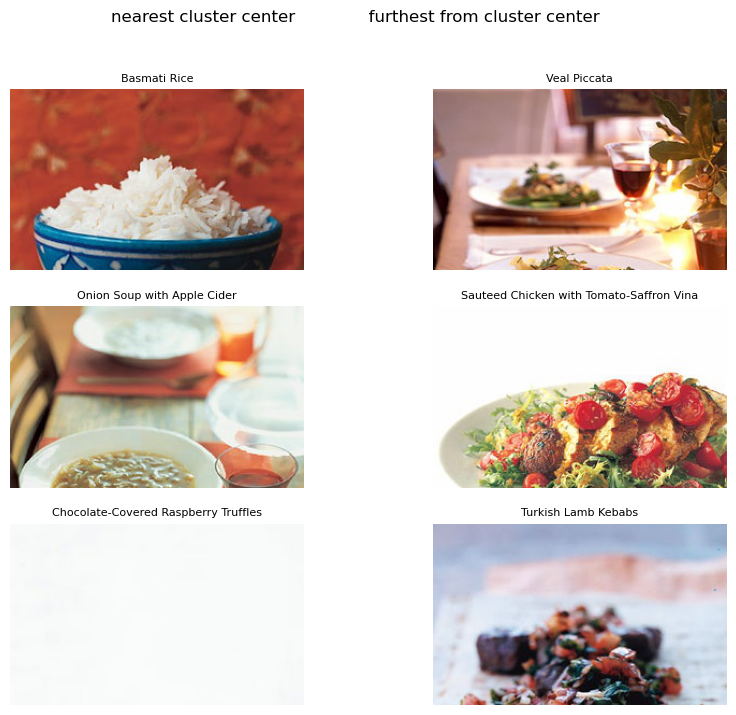

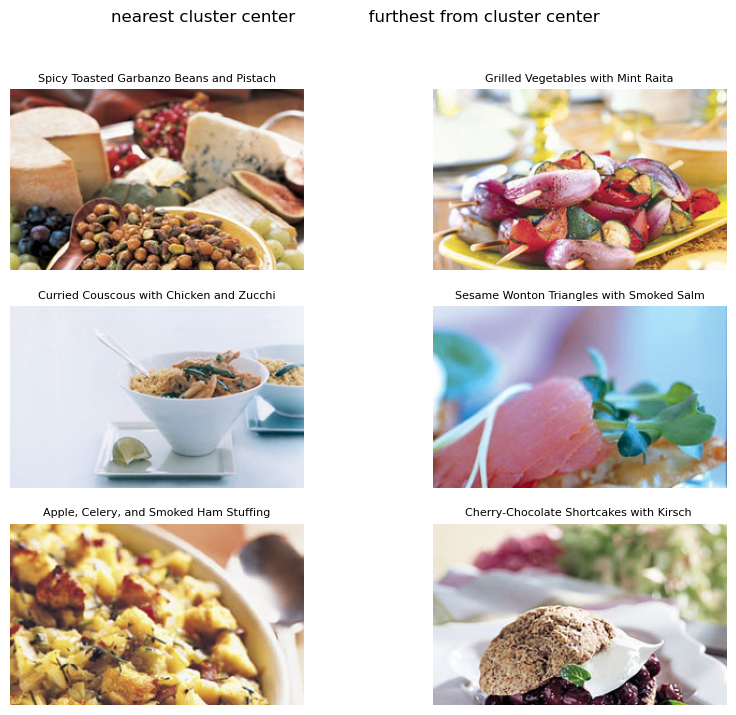

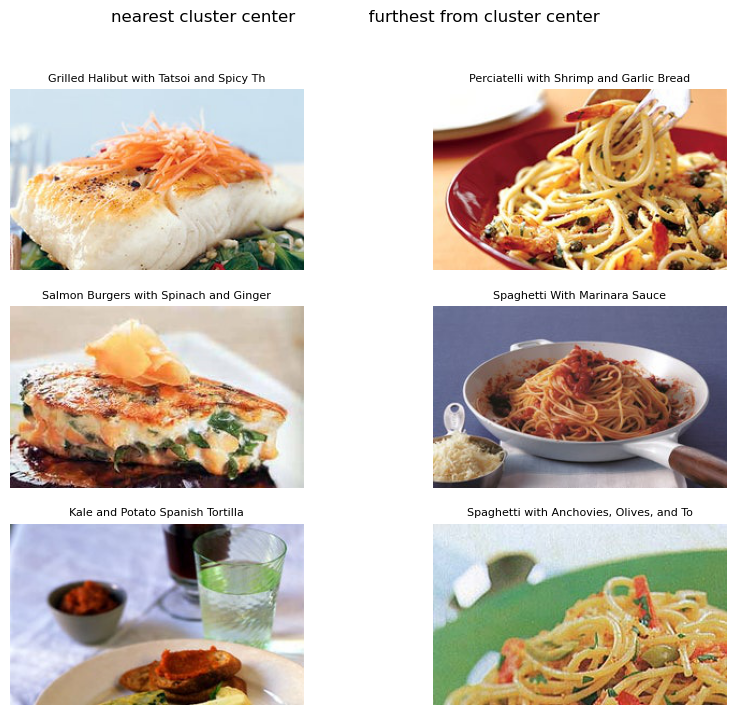

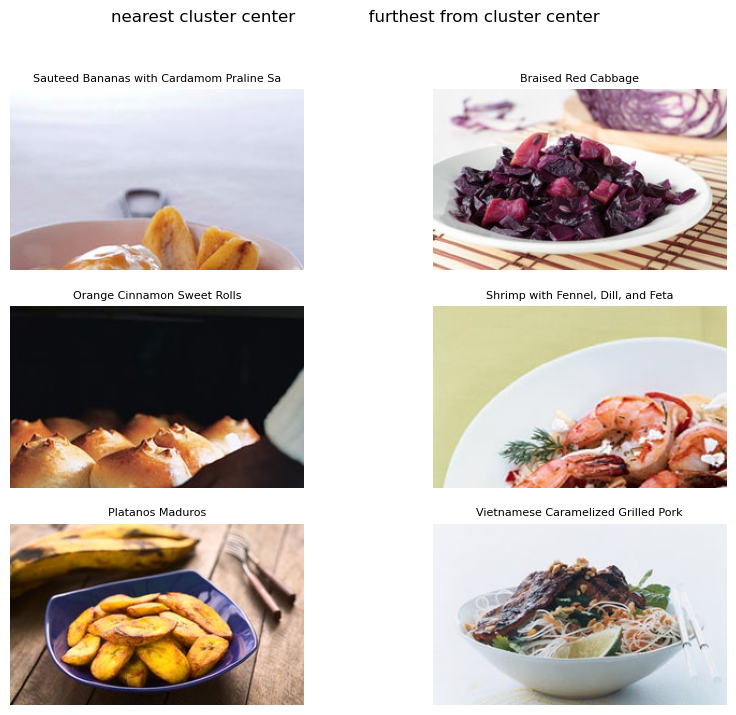

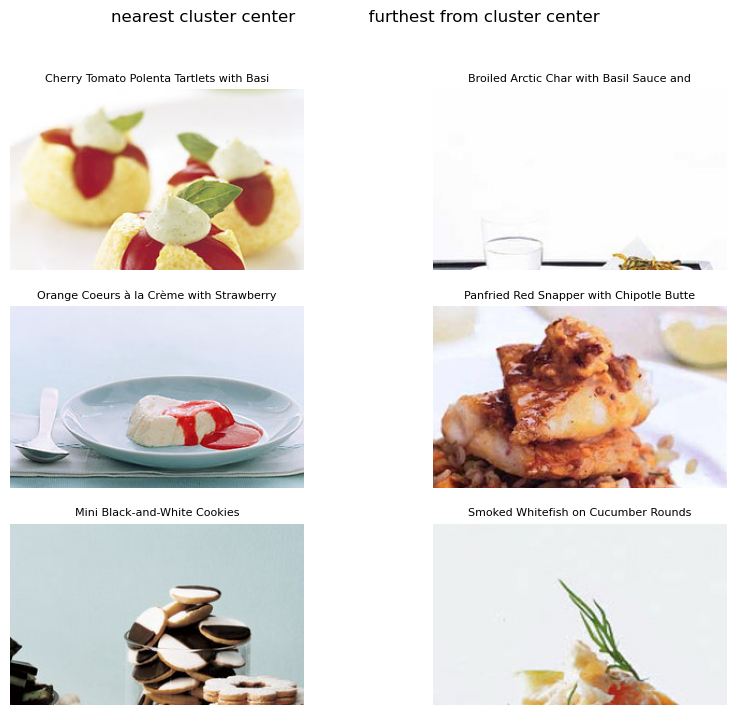

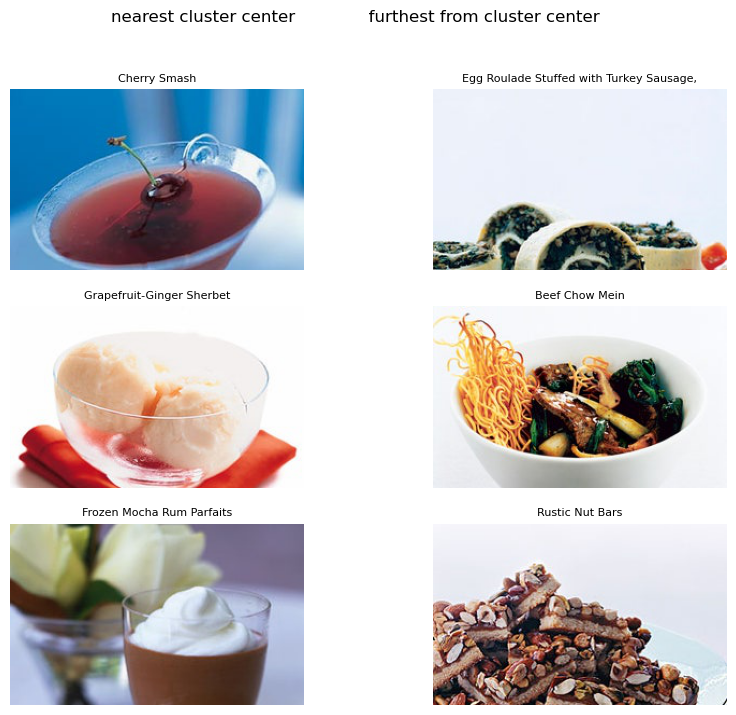

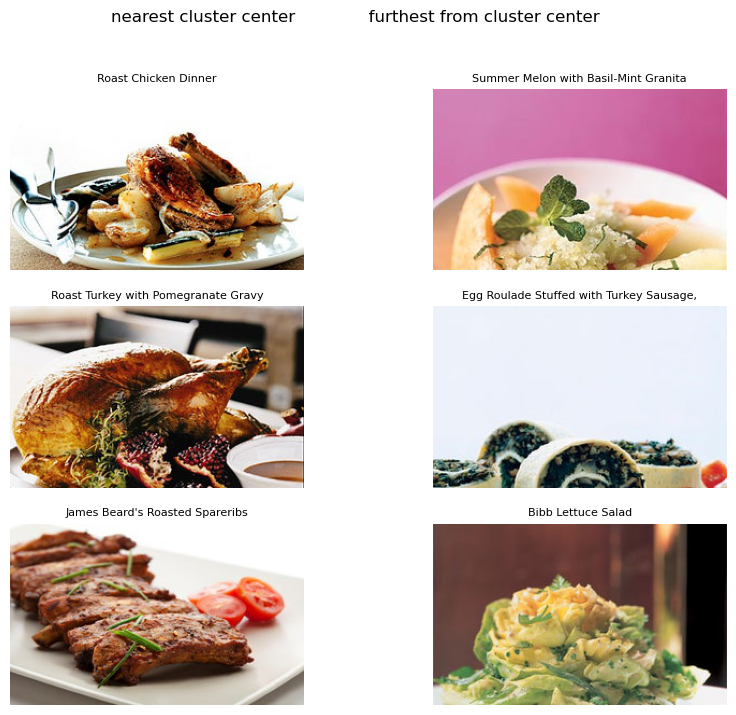

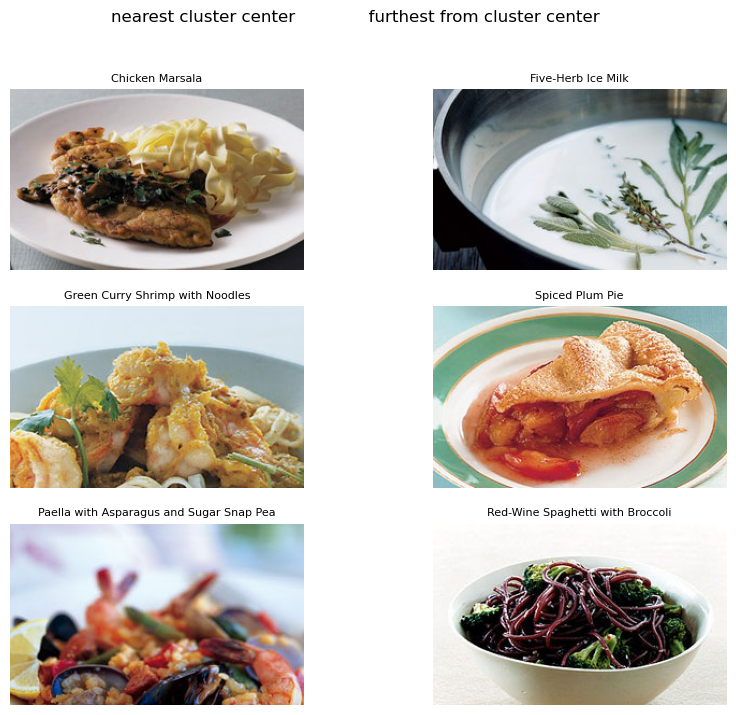

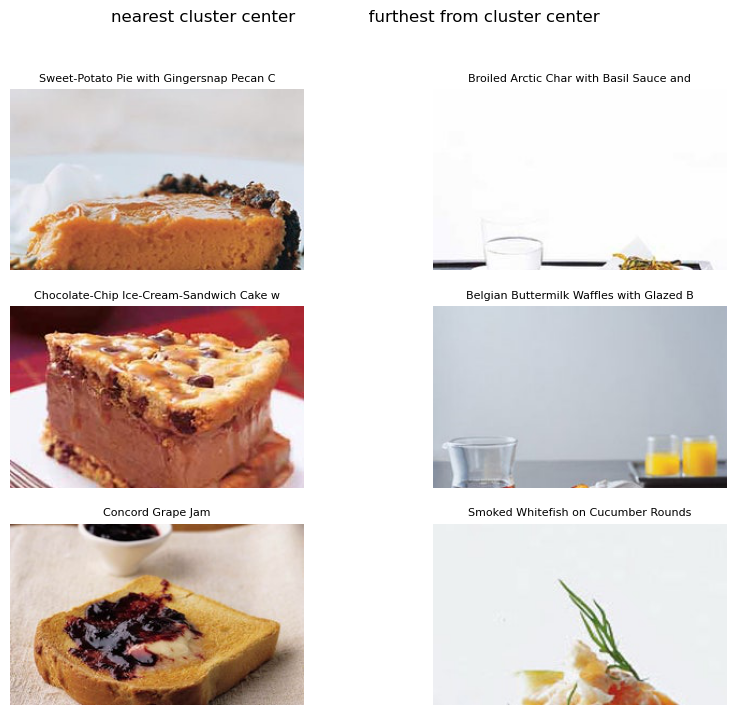

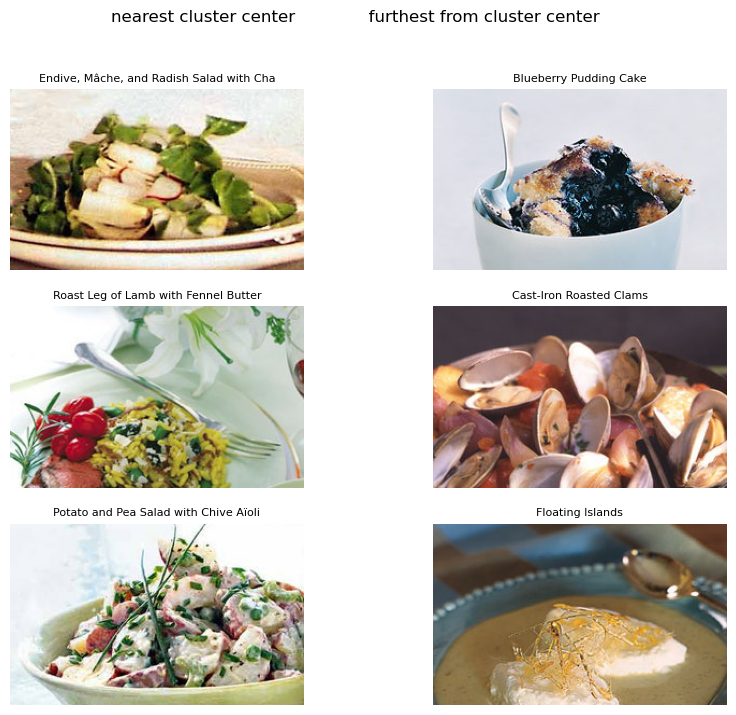

In [9]:
dist_to_cluster = Kmeans_model_img.transform(img_embs)


top_x_of_each_cluster = 3

color_fuckery = True # for some reason adding axis and fig lables inverts som of the colors
for cluster in range(n_clusters):
    cur_cluster = dist_to_cluster[:, cluster]
    cur_cluster_arg_sort = np.argsort(cur_cluster)
    best_idx = cur_cluster_arg_sort[:top_x_of_each_cluster]
    worst_idx = reversed(cur_cluster_arg_sort[-top_x_of_each_cluster:])

    fig, axes = plt.subplots(nrows=top_x_of_each_cluster, ncols=2, figsize=(10,8))
    if color_fuckery: fig.suptitle(f"nearest cluster center              furthest from cluster center")
    for i, idx in enumerate(best_idx): 
        food_pic = data_set_NO_transf[idx][0]
        axes[i, 0].imshow(food_pic)
        axes[i, 0].axis("off")
        if color_fuckery: axes[i,0].set_title(data_set_NO_transf[idx][1][0][:40], fontsize=8)
    

    for i, idx in enumerate(worst_idx): 
        food_pic = data_set_NO_transf[idx][0]
        axes[i, 1].imshow(food_pic)
        axes[i, 1].axis("off")
        if color_fuckery: axes[i, 1].set_title(data_set_NO_transf[idx][1][0][:40], fontsize=8)
    #axes[1, 0].set_ylabel("worst")
    # if color_fuckery: fig.text(0.1,0.25, "furthers                            nearest", rotation=90)
    plt.show()


    
